### Try CNN

In [ ]:
import torch
import torch.nn as nn

m = nn.Conv1d(1, 1, 3, stride=1, padding='same')
m.weight.data.fill_(1)
m.bias.data.fill_(0)
maxpool = nn.MaxPool1d(2, stride=2)

with torch.no_grad():
    input = torch.zeros(1, 1, 6)
    input[0, 0, :3] = 1
    print('input', input)

    output = m(input)
    print('output', output)

    output = maxpool(output)
    print('pooled output', output)


input tensor([[[1., 1., 1., 0., 0., 0.]]])
output tensor([[[2., 3., 2., 1., 0., 0.]]])
pooled output tensor([[[3., 2., 0.]]])


In [ ]:
class ConvNet1D(nn.Module):
    def __init__(self, input_len):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 1, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool1d(2))
        self.layer2 = nn.Sequential(
            nn.Linear(input_len//2, 2),
            nn.Tanh())
    
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.layer2(out)
        return out

In [ ]:
x_gpt4_orig = get_features('../data/gpt-4/pubmed_Ans_gpt-4.original.gpt2xl.fftnorm.txt')
y_gpt4_orig = np.zeros(x_gpt4_orig.shape[0])

x_gpt4_samp = get_features('../data/gpt-4/pubmed_Ans_gpt-4.sampled.gpt2xl.fftnorm.txt')
y_gpt4_samp = np.ones(x_gpt4_samp.shape[0])

freq_left_end = 0.0
freq_right_end = 0.5
x_gpt4_orig = x_gpt4_orig[:, int(freq_left_end/0.5 * x_gpt4_orig.shape[1]): int(freq_right_end/0.5 * x_gpt4_orig.shape[1])]
x_gpt4_samp = x_gpt4_samp[:, int(freq_left_end/0.5 * x_gpt4_samp.shape[1]): int(freq_right_end/0.5 * x_gpt4_samp.shape[1])]

x_gpt4 = np.concatenate([x_gpt4_orig, x_gpt4_samp], axis=0)
y_gpt4 = np.concatenate([y_gpt4_orig, y_gpt4_samp], axis=0)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x_gpt4, y_gpt4, test_size=0.2, random_state=42)

print('train:', x_train.shape, y_train.shape)
print('test:', x_test.shape, y_test.shape)

train: (240, 500) (240,)
test: (60, 500) (60,)


In [ ]:
left_end = 0.2
right_end = 0.5
left_end_idx = int(left_end/0.5 * x_gpt4.shape[1])
right_end_idx = int(right_end/0.5 * x_gpt4.shape[1])

x_train_tensor = torch.from_numpy(x_train[:, left_end_idx:right_end_idx])
x_test_tensor = torch.from_numpy(x_test[:, left_end_idx:right_end_idx])
y_train_tensor = torch.from_numpy(y_train)
y_test_tensor = torch.from_numpy(y_test)

print(x_train_tensor.shape)

model = ConvNet1D(x_train_tensor.shape[1])

torch.Size([240, 300])


In [ ]:
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 500
batch_size = 16 
acc_list = []
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    for i in range(0, x_train_tensor.size(0), batch_size):
        x_batch = x_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(x_batch.unsqueeze(1).float())
        loss = criterion(outputs, y_batch.long())
        loss.backward()
        optimizer.step()

    outputs = model(x_test_tensor.unsqueeze(1).float())
    _, predicted = torch.max(outputs, 1)
    total = y_test_tensor.size(0)
    correct = (predicted == y_test_tensor).sum().item()
    acc = correct / total
    acc_list.append(acc)
    pbar.set_description('Epoch [{}/{}], Loss: {:.4f}, Test Acc: {:.2f}'.format(epoch+1, num_epochs, loss.item(), acc))


print('Best test acc:', max(acc_list))

Epoch [500/500], Loss: 0.3983, Test Acc: 0.53: 100%|██████████| 500/500 [00:11<00:00, 44.83it/s]

Best test acc: 0.6


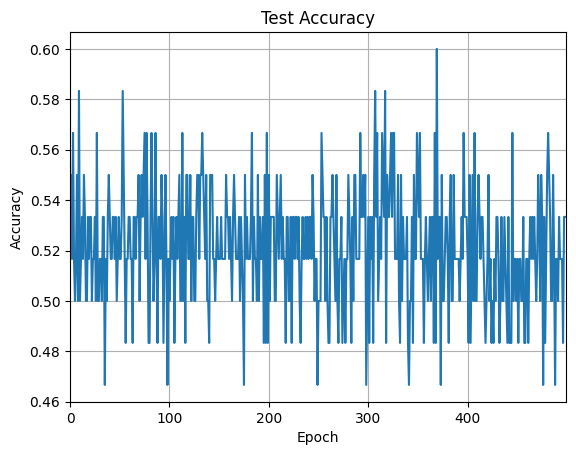

In [ ]:
import matplotlib.pyplot as plt

#plot the test accuracy
plt.title('Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(acc_list)
plt.show()